In [1]:
#imports
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm as tqdm
from numba import njit

# The Potts Model
Using the Potts Model to reproduce the results from the Landau paper. Much of the code will be reused and tweaked from the Ising model

In [22]:
'''Functions'''
#Hamiltonian
@njit
def hamiltonian(J, spin_grid):
    energy=0
    for ii in range(len(spin_grid)):
        for jj in range(len(spin_grid)):
            #Check if the spin above is equal 
            if spin_grid[ii, ((jj+1)%len(spin_grid))]==spin_grid[ii, jj]:
                energy+=1
            #Check if the spin to the right is equal 
            if spin_grid[((ii+1)%(len(spin_grid))), jj]==spin_grid[ii, jj]:
                energy+=1
            #Only do right and above due to torus boundary conditions 
            #to avoid double counting 
    #Multiply by coupling constant 
    energy*=J
    return energy

#Spin grid generator
@njit
def lattice_generator(N, q):
    lattice=np.zeros((N,N))
    for ii in range(N):
        for jj in range(N):
            lattice[ii, jj]=np.random.randint(q) 
    return lattice

#Monte Carlo interator 
@njit
def average_energy_calculator(N, q, J, iterations, inv_beta):
    #Start with random configuration of spins
    spins_original=lattice_generator(N, q)
    
    #Store initial energy
    energy=np.zeros(iterations)
    energy[0]=hamiltonian(J, spins_original)
    
    for jj in range(1, iterations):
        track=0
        while energy[jj]==0:
            #Continuously flips spins until it finds a configuration of lower energy
            track+=1
            location_x=np.random.randint(N)
            location_y=np.random.randint(N)
            #Placeholder spin array
            spins_holder=spins_original.copy()
            #Change spin at random generated point 
            spins_holder[location_x, location_y]=np.random.randint(q)

            #Calculate change in energy 
            dE=hamiltonian(J, spins_holder) - hamiltonian(J, spins_original)
            if np.exp(-dE/inv_beta)>np.random.uniform(0,1) or track>=500:
                #Becomes new configuration for the spins 
                #Include a breakout clause if the system gets stuck
                spins_original=spins_holder.copy()
                energy[jj]=hamiltonian(J,spins_original)
                
    #Return the average energy 
    return (1/(N**2))*np.mean(energy)

#Return the energy array for a given temperature 
@njit
def energy_calculator(N, q, J, iterations, inv_beta):
    #Start with random configuration of spins
    spins_original=lattice_generator(N, q)
    
    #Store initial energy
    energy=np.zeros(iterations)
    energy[0]=hamiltonian(J, spins_original)
    energy_store=np.zeros(int(200))
    energy_store[0]=energy[0]
    
    for jj in range(1, iterations):
        track=0
        while energy[jj]==0:
            #Continuously flips spins until it finds a configuration of lower energy
            track+=1
            location_x=np.random.randint(N)
            location_y=np.random.randint(N)
            #Placeholder spin array
            spins_holder=spins_original.copy()
            #Change spin at random generated point 
            spins_holder[location_x, location_y]=np.random.randint(q)

            #Calculate change in energy 
            dE=hamiltonian(J, spins_holder) - hamiltonian(J, spins_original)
            if np.exp(-dE/inv_beta)>np.random.uniform(0,1) or track>=500:
                #Becomes new configuration for the spins 
                #Include a breakout clause if the system gets stuck
                spins_original=spins_holder.copy()
                energy[jj]=hamiltonian(J,spins_original)
                #Store every 5000th entry
                if jj%5000==0 or jj==iterations:
                    energy_store[int(jj/5000)]=energy[jj]
                
    #Return the average energy 
    return (1/(N**2))*energy_store

## Reproducing the Ising model

In [3]:
#Variables and constants 
iterations=int(1e6)
db=0.1
inv_beta=np.arange(4.5, 0-db, -db)
q=2
J=1

In [4]:
#N=4 grid 
energy_4=np.zeros(len(inv_beta))
for ii in tqdm(range(len(inv_beta))):
    energy_4[ii]=average_energy_calculator(4, q, J, iterations, inv_beta[ii])
    
#N=8 grid
energy_8=np.zeros(len(inv_beta))
for ii in tqdm(range(len(inv_beta))):
    energy_8[ii]=average_energy_calculator(8, q, J, iterations, inv_beta[ii])
    
#N=16 grid
energy_16=np.zeros(len(inv_beta))
for ii in tqdm(range(len(inv_beta))):
    energy_16[ii]=average_energy_calculator(16, q, J, iterations, inv_beta[ii])

<IPython.core.display.Javascript object>


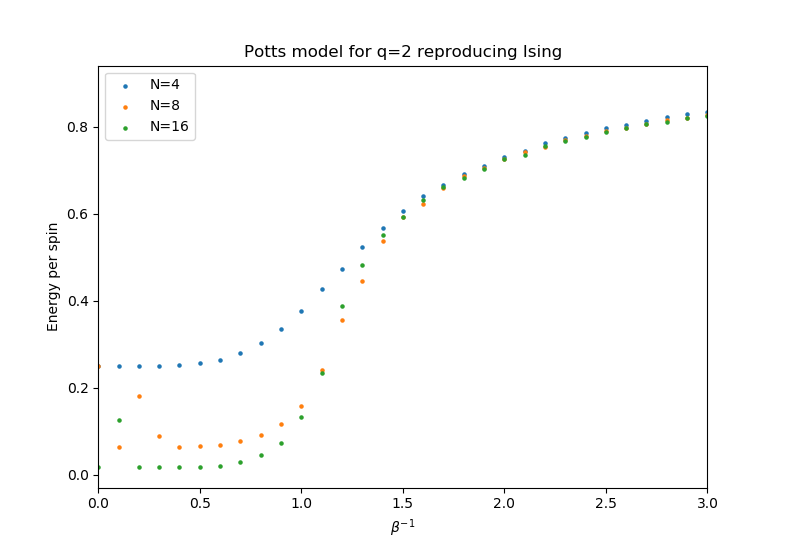

In [5]:
#Plotting and results 
%matplotlib notebook
plt.scatter(inv_beta, energy_4, label='N=4', s=5)
plt.scatter(inv_beta, energy_8, label='N=8', s=5)
plt.scatter(inv_beta, energy_16, label='N=16', s=5)
plt.xlabel(r'$\beta^{-1}$')
plt.ylabel('Energy per spin')
plt.title('Potts model for q=2 reproducing Ising')
plt.xlim((0,3))
plt.legend()

## q=10 and change of E near the critical temperature 

In [6]:
#Variables and constants 
q=10
iterations=int(1e6)
db=0.1
inv_beta=np.arange(4.5, 0-db, -db)
J=1

In [7]:
#N=4 grid 
energy_4=np.zeros(len(inv_beta))
for ii in tqdm(range(len(inv_beta))):
    energy_4[ii]=average_energy_calculator(4, q, J, iterations, inv_beta[ii])
    
#N=16 grid
energy_16=np.zeros(len(inv_beta))
for ii in tqdm(range(len(inv_beta))):
    energy_16[ii]=average_energy_calculator(16, q, J, iterations, inv_beta[ii])
    
#N=50 grid
energy_50=np.zeros(len(inv_beta))
for ii in tqdm(range(len(inv_beta))):
    energy_50[ii]=average_energy_calculator(50, q, J, iterations, inv_beta[ii])

In [51]:
#Energy fluctuations near Tc
Tc=1.75
energy_fluct=energy_calculator(20, q, J, iterations, Tc)

<IPython.core.display.Javascript object>


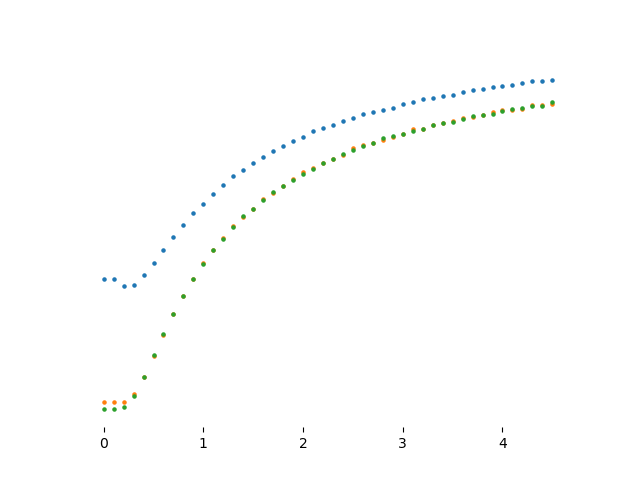

In [9]:
#Plotting and results 
plt.scatter(inv_beta, energy_4, label='N=4', s=5)
plt.scatter(inv_beta, energy_16, label='N=16', s=5)
plt.scatter(inv_beta, energy_50, label='N=50', s=5)
plt.xlabel('r$\beta^{-1}$')
plt.ylabel('Energy per spin')
plt.title('Potts model for q=10')
plt.legend()

<IPython.core.display.Javascript object>


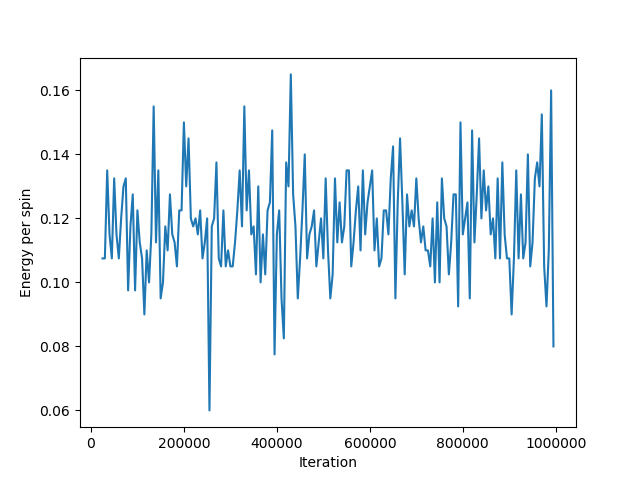

Text(0, 0.5, 'Energy per spin')

In [52]:
#Energy fluctuations plot
verify_its=np.zeros(200)
for ii in range(1,iterations):
    if ii%5000==0:
        verify_its[int(ii/5000)]=ii
        
plt.plot(verify_its[5:], energy_fluct[5:])
plt.xlabel('Iteration')
plt.ylabel('Energy per spin')

<IPython.core.display.Javascript object>


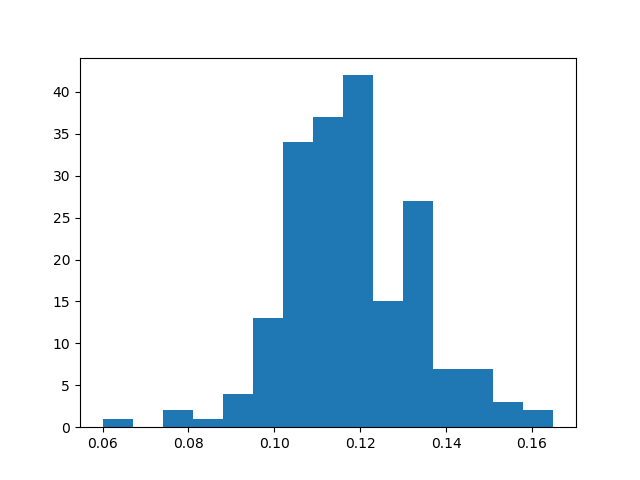

(array([ 1.,  0.,  2.,  1.,  4., 13., 34., 37., 42., 15., 27.,  7.,  7.,
         3.,  2.]),
 array([0.06 , 0.067, 0.074, 0.081, 0.088, 0.095, 0.102, 0.109, 0.116,
        0.123, 0.13 , 0.137, 0.144, 0.151, 0.158, 0.165]),
 <a list of 15 Patch objects>)

In [53]:
plt.hist(energy_fluct[5:], bins=15)